In [ ]:
# upgrade pip tooling first
# %pip install -q --upgrade pip setuptools wheel

# remove any conflicting wheels that may be half-installed
# %pip uninstall -y -q numpy scipy scikit-learn array-api-compat

# install a compatible trio for Python 3.12
# %pip install -q --no-cache-dir --force-reinstall \
#  "numpy==2.1.2" "scipy==1.14.1" "scikit-learn==1.5.2"


In [ ]:
# import os, time
# print("Restarting runtime to finalize installs…")
# time.sleep(1)
# os._exit(0)


In [7]:
!pip install -q transformers torch scikit-learn

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer,
    AutoTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [9]:
from google.colab import files
uploaded = files.upload()

Saving combined_emotion.csv to combined_emotion.csv
Saving combined_sentiment_data.csv to combined_sentiment_data.csv


# Imports + versions

In [10]:
import os, re, unicodedata, inspect
import numpy as np
import pandas as pd

import numpy as _np, scipy as _scipy, sklearn as _sk
print("NumPy:", _np.__version__)
print("SciPy:", _scipy.__version__)
print("sklearn:", _sk.__version__)


NumPy: 2.0.2
SciPy: 1.16.3
sklearn: 1.6.1


# Load both CSVs (raw)

In [11]:
SENTIMENT_CSV = "combined_sentiment_data.csv"
EMOTIONS_CSV  = "combined_emotion.csv"


read_opts = dict(
    dtype=str,
    na_values=["", " ", "NA", "NaN", "nan", None],
    keep_default_na=True,
    on_bad_lines="skip",
    encoding_errors="replace"
)

df_sent_raw = pd.read_csv(SENTIMENT_CSV, **read_opts)
df_emot_raw = pd.read_csv(EMOTIONS_CSV, **read_opts)

def guess_cols(df):
    candidates_text  = {"text","tweet","content","sentence","comment","body","review"}
    candidates_label = {"label","sentiment","target","polarity","emotion"}
    text_col  = next((c for c in df.columns if c.lower() in candidates_text),  df.columns[0])
    label_col = next((c for c in df.columns if c.lower() in candidates_label), df.columns[-1])
    return text_col, label_col

sent_text_col, sent_label_col = guess_cols(df_sent_raw)
emot_text_col, emot_label_col = guess_cols(df_emot_raw)

print("Sentiment shape:", df_sent_raw.shape, "| guessed:", sent_text_col, "/", sent_label_col)
print("Emotion   shape:", df_emot_raw.shape, "| guessed:", emot_text_col, "/", emot_label_col)


Sentiment shape: (3309, 2) | guessed: sentence / sentiment
Emotion   shape: (422746, 2) | guessed: sentence / emotion


# Clean + encode (for both datasets)

In [12]:
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df_raw, text_col, label_col):
    df = df_raw.rename(columns={text_col: "text", label_col: "label"}).copy()
    df = df.dropna(subset=["text","label"])
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"].str.len() > 0]

    # dedupe to avoid leakage later
    df["_norm"] = (
        df["text"].str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    df = df.drop_duplicates(subset=["_norm","label"]).drop(columns=["_norm"]).reset_index(drop=True)

    # label encode
    le = LabelEncoder()
    df["label_encoded"] = le.fit_transform(df["label"].astype(str))
    id2label = {i: lab for i, lab in enumerate(le.classes_)}
    label2id = {lab: i for i, lab in id2label.items()}
    return df, id2label, label2id, len(id2label)

df_sent, id2label_sent, label2id_sent, num_labels_sent = clean_and_encode(df_sent_raw, sent_text_col, sent_label_col)
df_emot, id2label_emot, label2id_emot, num_labels_emot = clean_and_encode(df_emot_raw, emot_text_col, emot_label_col)

print(f"[Sentiment] rows={len(df_sent)} classes={num_labels_sent}")
print(f"[Emotion]   rows={len(df_emot)} classes={num_labels_emot}")


[Sentiment] rows=3286 classes=2
[Emotion]   rows=416123 classes=6


# Build a combined multitask dataframe

In [13]:
import pandas as pd
import numpy as np

IGNORE_INDEX = -100  # tells CE loss to ignore missing labels

# Rename encoded columns to task-specific names
sent_df = df_sent[["text", "label_encoded"]].rename(columns={"label_encoded": "label_sent"})
emot_df = df_emot[["text", "label_encoded"]].rename(columns={"label_encoded": "label_emot"})

# Tag rows and add masked columns
sent_df["label_emot"] = IGNORE_INDEX
emot_df["label_sent"] = IGNORE_INDEX

# Union of both datasets (rows from each carry one valid label and one masked)
mtl_df = pd.concat([sent_df, emot_df], ignore_index=True)

# (Optional) Shuffle for mixing tasks
mtl_df = mtl_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Quick peek
print(mtl_df.head(3))
print("Counts:",
      "\n rows:", len(mtl_df),
      "\n sentiment-labeled:", (mtl_df["label_sent"] != IGNORE_INDEX).sum(),
      "\n emotion-labeled:  ", (mtl_df["label_emot"] != IGNORE_INDEX).sum())


                                                text  label_sent  label_emot
0            i still feel like the last tragic entry        -100           4
1  i know there have been a multitude of posts in...        -100           2
2  ive been feeling troubled and moody these days...        -100           4
Counts: 
 rows: 419409 
 sentiment-labeled: 3286 
 emotion-labeled:   416123


# Train/Val/Test split (stratify by “has which label”)

In [14]:
from sklearn.model_selection import train_test_split

RNG = 42
has_sent = (mtl_df["label_sent"] != IGNORE_INDEX).astype(int)
has_emot = (mtl_df["label_emot"] != IGNORE_INDEX).astype(int)

# We stratify by which task label exists to keep task mix similar across splits
train_df, hold_df = train_test_split(
    mtl_df, test_size=0.20, random_state=RNG,
    stratify=has_sent + 2*has_emot  # four combos (0/1 per task)
)
val_df, test_df = train_test_split(
    hold_df, test_size=0.50, random_state=RNG,
    stratify=(hold_df["label_sent"] != IGNORE_INDEX).astype(int) + 2*(hold_df["label_emot"] != IGNORE_INDEX).astype(int)
)

print("Sizes → train/val/test:", len(train_df), len(val_df), len(test_df))
print("Train task mix:",
      (train_df["label_sent"] != IGNORE_INDEX).sum(),
      (train_df["label_emot"] != IGNORE_INDEX).sum())


Sizes → train/val/test: 335527 41941 41941
Train task mix: 2629 332898


# Tokenizer + HF Datasets (labels per task)

In [15]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Running on CPU (this will be extremely slow!)")

CUDA available: True
GPU name: NVIDIA L4


In [16]:
!pip install -q transformers datasets evaluate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [17]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

import torch
from torch.utils.data import Dataset

class SimpleTextDataset(Dataset):
    def __init__(self, df, label_col):
        self.encodings = tokenizer(
            df["text"].tolist(),
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        self.labels = torch.tensor(df[label_col].astype(int).tolist())

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
mtl_df["label_sent"] -= mtl_df.loc[mtl_df["label_sent"] != -100, "label_sent"].min()
mtl_df["label_emot"] -= mtl_df.loc[mtl_df["label_emot"] != -100, "label_emot"].min()

In [19]:
from sklearn.model_selection import train_test_split

RNG = 42

# Sentiment task
sent_rows = mtl_df[mtl_df["label_sent"] != -100]
train_sent_df, hold_sent_df = train_test_split(
    sent_rows, test_size=0.2, random_state=RNG, stratify=sent_rows["label_sent"]
)
val_sent_df, test_sent_df = train_test_split(
    hold_sent_df, test_size=0.5, random_state=RNG, stratify=hold_sent_df["label_sent"]
)

# Emotion task
emot_rows = mtl_df[mtl_df["label_emot"] != -100]
train_emot_df, hold_emot_df = train_test_split(
    emot_rows, test_size=0.2, random_state=RNG, stratify=emot_rows["label_emot"]
)
val_emot_df, test_emot_df = train_test_split(
    hold_emot_df, test_size=0.5, random_state=RNG, stratify=hold_emot_df["label_emot"]
)

train_sent = SimpleTextDataset(train_sent_df, "label_sent")
val_sent   = SimpleTextDataset(val_sent_df, "label_sent")

train_emot = SimpleTextDataset(train_emot_df, "label_emot")
val_emot   = SimpleTextDataset(val_emot_df, "label_emot")

print("✅ Dataset sizes:")
print("Sentiment → train:", len(train_sent), "val:", len(val_sent))
print("Emotion   → train:", len(train_emot), "val:", len(val_emot))

✅ Dataset sizes:
Sentiment → train: 2628 val: 329
Emotion   → train: 332898 val: 41612


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [21]:
training_args_sent = TrainingArguments(
    output_dir="./sentiment_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs_sent",
    load_best_model_at_end=True,
)

training_args_emot = TrainingArguments(
    output_dir="./emotion_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs_emot",
    load_best_model_at_end=True,
)

num_labels_sent = len(id2label_sent)
num_labels_emot = len(id2label_emot)

model_sent = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels_sent,
    id2label=id2label_sent,
    label2id=label2id_sent
)

model_emot = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels_emot,
    id2label=id2label_emot,
    label2id=label2id_emot
)



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train sentiment

trainer_sent = Trainer(
    model=model_sent,
    args=training_args_sent,
    train_dataset=train_sent,
    eval_dataset=val_sent,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Training Sentiment Model...")
trainer_sent.train()

/tmp/ipython-input-2321616973.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_sent = Trainer(


Training Sentiment Model...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shalomwie (shalomwie-university-of-north-texas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.250932,0.927052,0.926981
2,No log,0.273853,0.939210,0.939212


TrainOutput(global_step=330, training_loss=0.27340744480942236, metrics={'train_runtime': 75.2023, 'train_samples_per_second': 69.891, 'train_steps_per_second': 4.388, 'total_flos': 345727926743040.0, 'train_loss': 0.27340744480942236, 'epoch': 2.0})

In [ ]:
from transformers import RobertaForSequenceClassification, AutoTokenizer

# Save sentiment model
model_sent.save_pretrained("final_sentiment_model")
tokenizer.save_pretrained("final_sentiment_model")

('final_sentiment_model/tokenizer_config.json',
 'final_sentiment_model/special_tokens_map.json',
 'final_sentiment_model/vocab.json',
 'final_sentiment_model/merges.txt',
 'final_sentiment_model/added_tokens.json',
 'final_sentiment_model/tokenizer.json')

In [ ]:
#Train emotion
trainer_emot = Trainer(
    model=model_emot,
    args=training_args_emot,
    train_dataset=train_emot,
    eval_dataset=val_emot,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Training Emotion Model...")
trainer_emot.train()

/tmp/ipython-input-3243999492.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_emot = Trainer(


Training Emotion Model...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.095500,0.101675,0.942685,0.941282


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.095500,0.101675,0.942685,0.941282
2,0.091200,0.092188,0.941675,0.943020


TrainOutput(global_step=41614, training_loss=0.11394590833492245, metrics={'train_runtime': 6720.6012, 'train_samples_per_second': 99.068, 'train_steps_per_second': 6.192, 'total_flos': 4.379614490878157e+16, 'train_loss': 0.11394590833492245, 'epoch': 2.0})

In [ ]:
from transformers import RobertaForSequenceClassification, AutoTokenizer

# Save emotion model
model_emot.save_pretrained("final_emotion_model")
tokenizer.save_pretrained("final_emotion_model")

('final_emotion_model/tokenizer_config.json',
 'final_emotion_model/special_tokens_map.json',
 'final_emotion_model/vocab.json',
 'final_emotion_model/merges.txt',
 'final_emotion_model/added_tokens.json',
 'final_emotion_model/tokenizer.json')

In [ ]:
!zip -r trained_models.zip final_sentiment_model final_emotion_model

  adding: final_sentiment_model/ (stored 0%)
  adding: final_sentiment_model/merges.txt (deflated 53%)
  adding: final_sentiment_model/config.json (deflated 52%)
  adding: final_sentiment_model/vocab.json (deflated 59%)
  adding: final_sentiment_model/special_tokens_map.json (deflated 52%)
  adding: final_sentiment_model/model.safetensors (deflated 14%)
  adding: final_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: final_sentiment_model/tokenizer.json (deflated 82%)
  adding: final_emotion_model/ (stored 0%)
  adding: final_emotion_model/merges.txt (deflated 53%)
  adding: final_emotion_model/config.json (deflated 53%)
  adding: final_emotion_model/vocab.json (deflated 59%)
  adding: final_emotion_model/special_tokens_map.json (deflated 52%)
  adding: final_emotion_model/model.safetensors (deflated 10%)
  adding: final_emotion_model/tokenizer_config.json (deflated 75%)
  adding: final_emotion_model/tokenizer.json (deflated 82%)


In [ ]:
from google.colab import files
files.download("trained_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp trained_models.zip /content/drive/MyDrive/

In [ ]:
def predict_with_percentages(text, model, tokenizer, id2label):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    # Get label with highest probability
    top_idx = probs.argmax()
    top_label = id2label[top_idx]
    top_score = probs[top_idx] * 100
    # Return top label + all percentages
    return top_label, top_score, {id2label[i]: round(float(p)*100, 2) for i, p in enumerate(probs)}

In [ ]:
sample_text = "I don't think I can handle this"

#Sentiment
sent_label, sent_score, sent_probs = predict_with_percentages(
    sample_text, model_sent, tokenizer_sent, model_sent.config.id2label
)

#Emotion
emot_label, emot_score, emot_probs = predict_with_percentages(
    sample_text, model_emot, tokenizer_emot, model_emot.config.id2label
)

#Display Results
print(f"Sentiment: {sent_label} ({sent_score:.1f}%)\n")

print("Top Emotions:")
for label, prob in sorted(emot_probs.items(), key=lambda x: x[1], reverse=True)[:3]:
    print(f"  {label}: {prob:.1f}%")

Sentiment: negative (98.1%)

Top Emotions:
  sad: 82.6%
  fear: 16.8%
  anger: 0.5%


**Reload saved models and run metrics**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
!cp /content/drive/MyDrive/trained_models.zip .

# unzip
!unzip -q trained_models.zip -d ./trained_models


replace ./trained_models/final_sentiment_model/merges.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_sentiment_model/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_sentiment_model/vocab.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_sentiment_model/special_tokens_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_sentiment_model/model.safetensors? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_sentiment_model/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_sentiment_model/tokenizer.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_emotion_model/merges.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_emotion_model/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./trained_models/final_emotion_model/vocab.json? [y]es, [n]o, [A]ll,

In [40]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

#Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Sentiment model
tokenizer_sent = AutoTokenizer.from_pretrained("./trained_models/final_sentiment_model")
model_sent = AutoModelForSequenceClassification.from_pretrained(
    "./trained_models/final_sentiment_model"
).to(device)

# Emotion model
tokenizer_emot = AutoTokenizer.from_pretrained("./trained_models/final_emotion_model")
model_emot = AutoModelForSequenceClassification.from_pretrained(
    "./trained_models/final_emotion_model"
).to(device)

print("Models loaded")

Using device: cuda
Models loaded


In [31]:
def evaluate_model(model, tokenizer, texts, labels):
    all_preds, all_labels = [], []
    model.eval()

    for text, label in zip(texts, labels):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        label_tensor = torch.tensor([label], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().item()
        all_preds.append(preds)
        all_labels.append(int(label))

    acc = accuracy_score(all_labels, all_preds)
    prec, recall, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro", zero_division=0)
    _, _, f1_micro, _ = precision_recall_fscore_support(all_labels, all_preds, average="micro", zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": recall,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "confusion_matrix": cm
    }



 Sentiment Metrics
accuracy: 0.9453
precision: 0.9457
recall: 0.9451
f1_macro: 0.9452
f1_micro: 0.9453


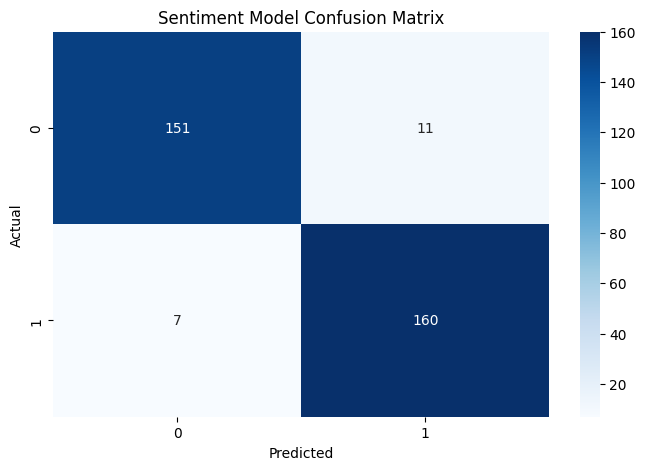

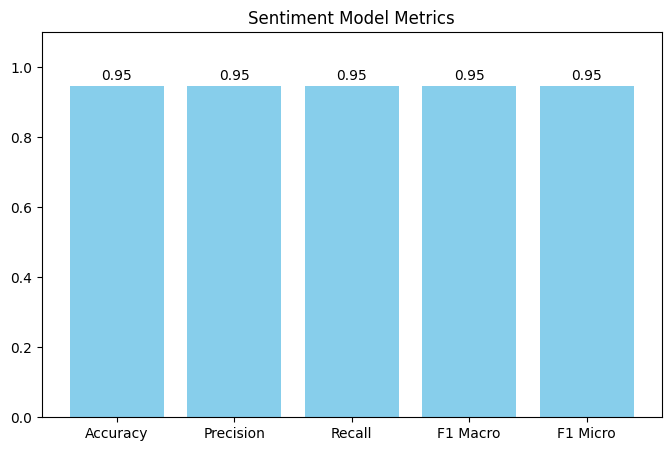

In [38]:
#Evaluate Sentiment
sent_mask = (test_sent_df["label_sent"] != -100) & test_sent_df["label_sent"].notna()
metrics_sent = evaluate_model(model_sent, tokenizer_sent,
                              test_sent_df.loc[sent_mask, "text"],
                              test_sent_df.loc[sent_mask, "label_sent"])

print("\n Sentiment Metrics")
for k, v in metrics_sent.items():
    if k != "confusion_matrix":
        print(f"{k}: {v:.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(8,5))
sns.heatmap(metrics_sent["confusion_matrix"], annot=True, fmt='d', cmap="Blues")
plt.title("Sentiment Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(
    ["Accuracy", "Precision", "Recall", "F1 Macro", "F1 Micro"],
    [metrics_sent["accuracy"], metrics_sent["precision"], metrics_sent["recall"],
     metrics_sent["f1_macro"], metrics_sent["f1_micro"]],
    color="skyblue"
)
plt.title("Sentiment Model Metrics")
plt.ylim(0, 1.1)
for bar, val in zip(bars, [metrics_sent["accuracy"], metrics_sent["precision"], metrics_sent["recall"],
                           metrics_sent["f1_macro"], metrics_sent["f1_micro"]]):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.05, f"{val:.2f}", ha='center', va='top', color='black')
plt.show()



 Emotion Metrics
accuracy: 0.9427
precision: 0.8964
recall: 0.9490
f1_macro: 0.9165
f1_micro: 0.9427


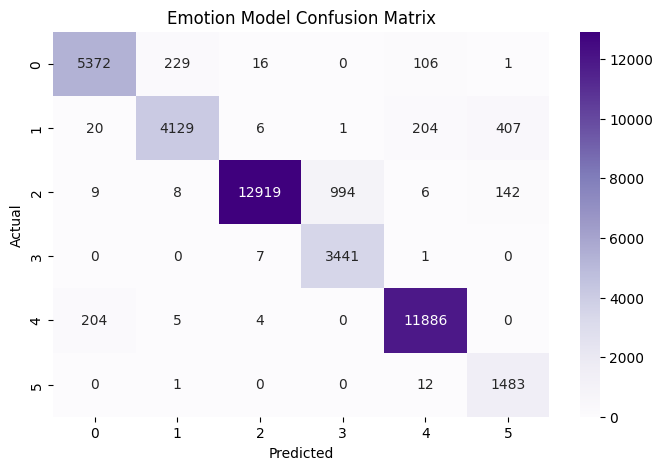

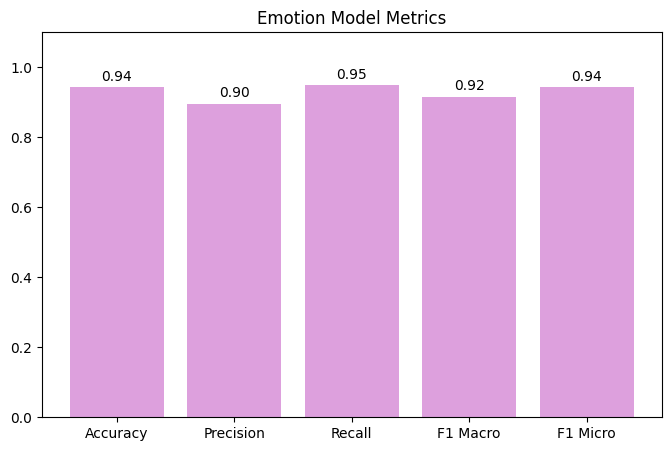

In [39]:
#Evaluate emotion
emot_mask = (test_emot_df["label_emot"] != -100) & test_emot_df["label_emot"].notna()
metrics_emot = evaluate_model(model_emot, tokenizer_emot,
                              test_emot_df.loc[emot_mask, "text"],
                              test_emot_df.loc[emot_mask, "label_emot"])

print("\n Emotion Metrics")
for k, v in metrics_emot.items():
    if k != "confusion_matrix":
        print(f"{k}: {v:.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(8,5))
sns.heatmap(metrics_emot["confusion_matrix"], annot=True, fmt='d', cmap="Purples")
plt.title("Emotion Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(
    ["Accuracy", "Precision", "Recall", "F1 Macro", "F1 Micro"],
    [metrics_emot["accuracy"], metrics_emot["precision"], metrics_emot["recall"],
     metrics_emot["f1_macro"], metrics_emot["f1_micro"]],
    color="plum"
)
plt.title("Emotion Model Metrics")
plt.ylim(0, 1.1)
for bar, val in zip(bars, [metrics_emot["accuracy"], metrics_emot["precision"], metrics_emot["recall"],
                           metrics_emot["f1_macro"], metrics_emot["f1_micro"]]):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.05, f"{val:.2f}", ha='center', va='top', color='black')
plt.show()